In [1]:
import torch
from matplotlib import pyplot as plt
import numpy as np

In [24]:
# Load the data from the NPZ file from shooting method to validate model
loaded_data = np.load('../shooting_method/data_all.npz')

# Access the arrays using the keys ('r', 'A0', 'alpha0', 'phi0')
r = loaded_data['r']
A0 = loaded_data['A0']
alpha0 = loaded_data['alpha0']
phi0 = loaded_data['phi0']


In [2]:
# copied from https://github.com/benmoseley/harmonic-oscillator-pinn/blob/main/Harmonic%20oscillator%20PINN.ipynb
class FCN(torch.nn.Module):    
    def __init__(self, N_INPUT, N_OUTPUT, N_HIDDEN, N_LAYERS):
        super().__init__()
        activation = torch.nn.Tanh
        
        self.fcs = torch.nn.Sequential(*[
                        torch.nn.Linear(N_INPUT, N_HIDDEN),
                        activation()])
        self.fch = torch.nn.Sequential(*[
                        torch.nn.Sequential(*[
                            torch.nn.Linear(N_HIDDEN, N_HIDDEN),
                            activation()]) for _ in range(N_LAYERS-1)])
        self.fce = torch.nn.Linear(N_HIDDEN, N_OUTPUT)

      # Apply custom weight initialization
        self.apply(self._init_weights)
    
    def forward(self, x):
        x = self.fcs(x)
        x = self.fch(x)
        x = self.fce(x)
        act = torch.nn.Softplus()
        x = act(x)
        return x

    def _init_weights(self, m):
        if isinstance(m, torch.nn.Linear):
            # Get the size of the previous layer (input size of the current layer)
            n = m.in_features # The number of input features to this layer
            # Set the range for uniform distribution as [-1/sqrt(n), 1/sqrt(n)]
            bound = 1 / np.sqrt(n)
            # Initialize weights with a uniform distribution in the range [-bound, bound]
            torch.nn.init.uniform_(m.weight, -bound, bound)
            
            # Initialize biases to zero, only if the layer has biases
            if m.bias is not None:
                torch.nn.init.constant_(m.bias, 0.0)

In [3]:
# copied from https://github.com/raimonluna/MachineLearningForStrongGravity/blob/main/Lecture1_Physics_Informed_Neural_Networks.ipynb
def gradients(outputs, inputs, order = 1):
    if order == 1:
        return torch.autograd.grad(outputs, inputs, grad_outputs=torch.ones_like(outputs), create_graph=True)[0]
    elif order > 1:
        return gradients(gradients(outputs, inputs, 1), inputs, order - 1)
    else:
        return outputs

In [4]:
# random (uniform) sample points in (0,1).
def random_domain_points(n):
    #x = torch.rand((n,1), requires_grad=True)
    xhigh = 0.5*torch.rand((int(n/2),1), requires_grad=True) + 0.5 # [0.5,1)
    xlow  = -0.5*torch.rand((int(n/2),1), requires_grad=True) + 0.5 # (0,0.5]
    x = torch.cat((xlow, xhigh),0)
    return x

In [5]:
#torch.manual_seed(123)

# input 1 (x), output 4 (A, alpha, phi, chi), 32 nodes per layer, 3 hidden layers
# (#input, #output,#neurons in each hidden layer, #of hidden layers)
model1 = FCN(1,4,64,4)#.to(device)
model2 = FCN(1,4,64,4)#.to(device)
model3 = FCN(1,4,64,4)#.to(device)
model4 = FCN(1,4,64,4)#.to(device)
model5 = FCN(1,4,64,4)#.to(device)


#optimizer = torch.optim.Adam(list(model.parameters())+[omega],lr=1e-4)
omega = 0.895042*torch.ones(1)#.to(device) 
phi0  = 0.05 * torch.ones(1)
#torch.nn.Parameter(0.895042*torch.ones(1))

In [6]:
# model1.state_dict().keys()

In [7]:
# model1.state_dict()['fce.weight'][0:1]

In [8]:
# model5.state_dict()['fce.weight'][0:1]

In [11]:

dir = "../models/neurons64_h_layers4_rmax100_n1000_sigma0.2/"

#load trained model
model1.load_state_dict(torch.load(dir + "model_epoch200000.pth"))
model2.load_state_dict(torch.load(dir + "model_epoch400000.pth"))
model3.load_state_dict(torch.load(dir + "model_epoch600000.pth"))
model4.load_state_dict(torch.load(dir + "model_epoch800000.pth"))
model5.load_state_dict(torch.load(dir + "model_epoch1000000.pth"))

# load total loss list
loss_list = np.load(dir + "total_loss.npz")["loss"]
# load individual losses
losses = np.load(dir + "losses.npz")["loss"]
# load learning rate list
lr_list = np.load(dir + "learning_rate.npz")["lr"]


/tmp/ipykernel_16442/1589374158.py:4: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model1.load_state_dict(torch.load(dir + "model_epoch200000.pth"))
/tmp/ipykernel_16442/15

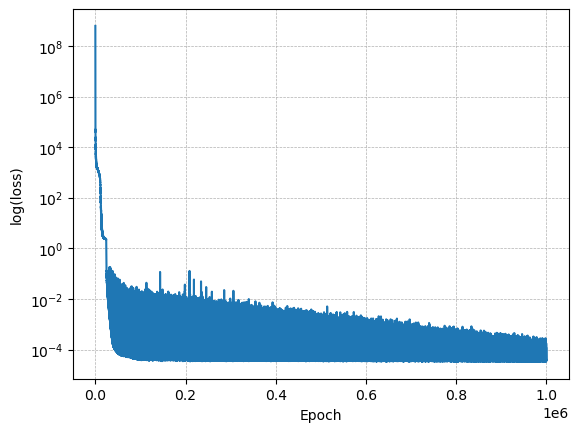

In [12]:
plt.semilogy(loss_list)
plt.xlabel("Epoch")
plt.ylabel("log(loss)")
plt.grid(True, which='both', linestyle='--', linewidth=0.5)

# Save the plot as a PNG file
#plt.savefig("./models/r_dom_fixed_omega_v3/loss.png", dpi=300, bbox_inches='tight')  # Save with high resolution
plt.show()  # Optional: Display the plot

Text(0, 0.5, 'log(losses[4])')

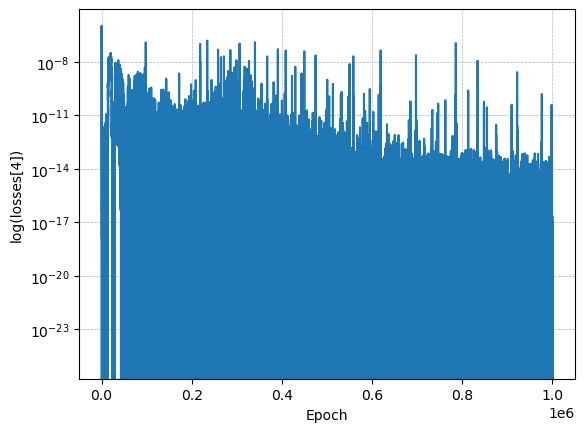

In [14]:
i = 4

ei = 0
ef = 1000000

# Plot in the second subplot
plt.semilogy(losses[i, ei:ef])
plt.grid(True, which='both', linestyle='--', linewidth=0.5)
plt.xlabel("Epoch")
plt.ylabel(f"log(losses[{i}])")

#plt.savefig(f"./models/r_dom_fixed_omega_v3/loss_{i}.png", dpi=300, bbox_inches='tight')  # Save with high resolution


Text(0.5, 0, 'lr')

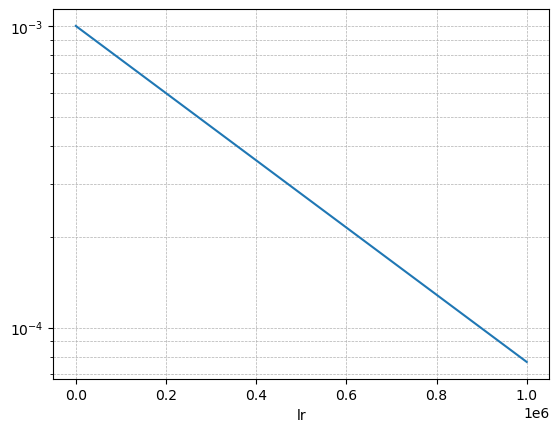

In [15]:
i = 1

ei = 0
ef = 5000000

# Plot in the second subplot
plt.semilogy(lr_list[ei:ef])
plt.grid(True, which='both', linestyle='--', linewidth=0.5)
plt.xlabel("lr")
#plt.ylabel(f"log(losses[{i}])")

#plt.savefig(f"./models/r_dom_fixed_omega_v3/loss_{i}.png", dpi=300, bbox_inches='tight')  # Save with high resolution


In [16]:
R0 = torch.zeros(1, requires_grad=True)#.to(device)
nn_sol_r01 = model1(R0)#.cpu().detach().numpy() # detach some extra info, and numpy makes a numpy array to plot
nn_sol_r02 = model2(R0)#.cpu().detach().numpy() # detach some extra info, and numpy makes a numpy array to plot
nn_sol_r03 = model3(R0)#.cpu().detach().numpy() # detach some extra info, and numpy makes a numpy array to plot
nn_sol_r04 = model4(R0)#.cpu().detach().numpy() # detach some extra info, and numpy makes a numpy array to plot
nn_sol_r05 = model5(R0)#.cpu().detach().numpy() # detach some extra info, and numpy makes a numpy array to plot
A1, alpha1, chi1, phi1 = map(lambda i:  nn_sol_r01[[i]], range(4))
alphar1 = gradients(alpha1, R0)
A2, alpha2, chi2, phi2 = map(lambda i:  nn_sol_r02[[i]], range(4))
alphar2 = gradients(alpha2, R0)
A3, alpha3, chi3, phi3 = map(lambda i:  nn_sol_r03[[i]], range(4))
alphar3 = gradients(alpha3, R0)
A4, alpha4, chi4, phi4 = map(lambda i:  nn_sol_r04[[i]], range(4))
alphar4 = gradients(alpha4, R0)
A5, alpha5, chi5, phi5 = map(lambda i:  nn_sol_r05[[i]], range(4))
alphar5 = gradients(alpha5, R0)

print("A_nn_r01 =",A1.item())
print("A_nn_r02 =",A2.item())
print("A_nn_r03 =",A3.item())
print("A_nn_r04 =",A4.item())
print("A_nn_r05 =",A5.item())
print("A_r0    =",1)
print("")

print("alpha_nn_r01 =",alpha1.item())
print("alpha_nn_r02 =",alpha2.item())
print("alpha_nn_r03 =",alpha3.item())
print("alpha_nn_r04 =",alpha4.item())
print("alpha_nn_r05 =",alpha5.item())
print("alpha_r0    >",0)
print("")

print("chi_nn_r01 =",chi1.item())
print("chi_nn_r02 =",chi2.item())
print("chi_nn_r03 =",chi3.item())
print("chi_nn_r04 =",chi4.item())
print("chi_nn_r05 =",chi5.item())
print("chi_r0    =",0)
print("")

print("phi_nn_r01 =",phi1.item())
print("phi_nn_r02 =",phi2.item())
print("phi_nn_r03 =",phi3.item())
print("phi_nn_r04 =",phi4.item())
print("phi_nn_r05 =",phi5.item())
print("phi0_r0   =",phi0.item())
print("")

print("alphar_nn_r01 =",alphar1.item())
print("alphar_nn_r02 =",alphar2.item())
print("alphar_nn_r03 =",alphar3.item())
print("alphar_nn_r04 =",alphar4.item())
print("alphar_nn_r05 =",alphar5.item())
print("alphar_r0    =",0)

A_nn_r01 = 0.9993425607681274
A_nn_r02 = 0.9998638033866882
A_nn_r03 = 1.0000447034835815
A_nn_r04 = 0.9999536275863647
A_nn_r05 = 1.0000126361846924
A_r0    = 1

alpha_nn_r01 = 0.8456417322158813
alpha_nn_r02 = 0.8542954921722412
alpha_nn_r03 = 0.8532335758209229
alpha_nn_r04 = 0.8528775572776794
alpha_nn_r05 = 0.8528017997741699
alpha_r0    > 0

chi_nn_r01 = 1.1085251117037842e-06
chi_nn_r02 = 1.8835090713764657e-06
chi_nn_r03 = 1.1542974789335858e-06
chi_nn_r04 = 9.9376188700262e-07
chi_nn_r05 = 8.431117066720617e-07
chi_r0    = 0

phi_nn_r01 = 0.04994846135377884
phi_nn_r02 = 0.04992590844631195
phi_nn_r03 = 0.04999634250998497
phi_nn_r04 = 0.05000252649188042
phi_nn_r05 = 0.05000055208802223
phi0_r0   = 0.05000000074505806

alphar_nn_r01 = 9.034890240400273e-07
alphar_nn_r02 = -5.070557563158218e-06
alphar_nn_r03 = -5.131380476086633e-08
alphar_nn_r04 = -4.5560130956801004e-07
alphar_nn_r05 = -3.8797799106760067e-07
alphar_r0    = 0


In [18]:
RMAX = 30
rmax = RMAX*torch.ones(1, requires_grad=True)#.to(device)
nn_sol_rmax = model5(rmax)#.cpu().detach().numpy() # detach some extra info, and numpy makes a numpy array to plot
A, alpha, chi, phi = map(lambda i:  nn_sol_rmax[[i]], range(4))
alphar = gradients(alpha, rmax)

print("A_nn_rmax =",A.item())
print("A_rmax    =",1)
print("")

print("alpha_nn_rmax =",alpha.item())
print("alpha_rmax    =",1)
print("")

print("chi_nn_rmax =",chi.item())
print("chi_rmax    =",0)
print("")

print("phi_nn_rmax =",phi.item())
print("phi0_rmax   =",0)

A_nn_rmax = 1.0227341651916504
A_rmax    = 1

alpha_nn_rmax = 0.9927567839622498
alpha_rmax    = 1

chi_nn_rmax = 1.2563625140238344e-10
chi_rmax    = 0

phi_nn_rmax = 7.660887604288291e-06
phi0_rmax   = 0


In [12]:
#plt.plot(omegas)

In [19]:
# the time domain; used to visualize the analytical solution
N = 1000
R = torch.linspace(0,RMAX,N)#.view(-1,10)
#print(t)

# the view(-1,1) make the row tensor to a column tensor
# -1 means you dont know how many rows you need, and 1 mean that you want 1 element in each row
RR = torch.linspace(0,RMAX,N).view(-1,1)#.to(device)

nn_sol1 = model1(RR).cpu().detach().numpy() # detach some extra info, and numpy makes a numpy array to plot
nn_sol5 = model5(RR).cpu().detach().numpy() # detach some extra info, and numpy makes a numpy array to plot
A_nn1, alpha_nn1, chi_nn1, phi_nn1 = map(lambda i:  nn_sol1[:,[i]], range(4))
A_nn5, alpha_nn5, chi_nn5, phi_nn5 = map(lambda i:  nn_sol5[:,[i]], range(4))


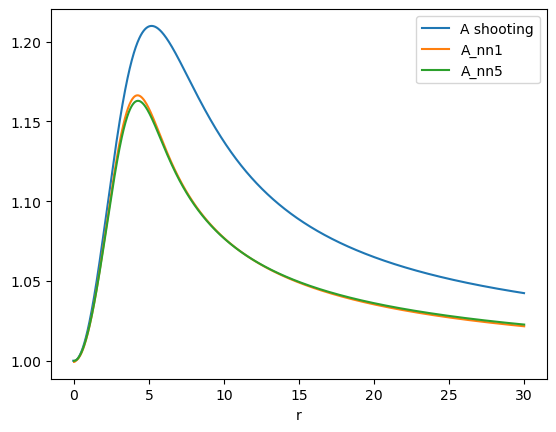

In [30]:
plt.plot(r, A0, label="A shooting")
plt.plot(R, A_nn1, label="A_nn1")
plt.plot(R, A_nn5, label="A_nn5")
#plt.plot(R, A_nn5-A_nn1, label="A_nn5-A_nn1")

plt.xlabel("r")
plt.legend()

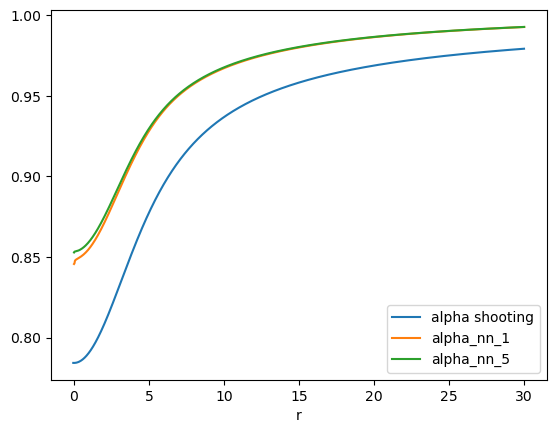

In [27]:
plt.plot(r, alpha0, label="alpha shooting")
plt.plot(R, alpha_nn1, label="alpha_nn_1")
plt.plot(R, alpha_nn5, label="alpha_nn_5")

plt.xlabel("r")
plt.legend()

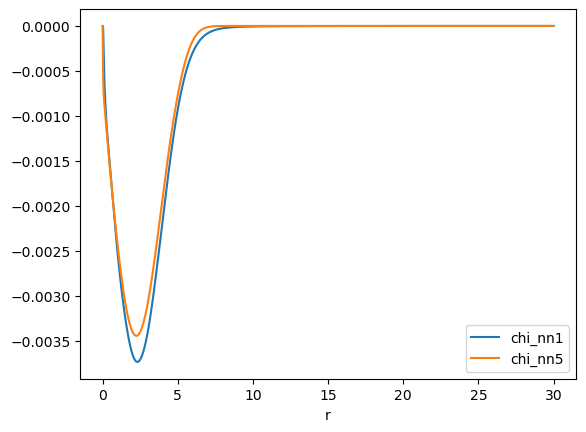

In [28]:
plt.plot(R, -chi_nn1, label="chi_nn1")
plt.plot(R, -chi_nn5, label="chi_nn5")

plt.xlabel("r")
plt.legend()

[0.04994846]


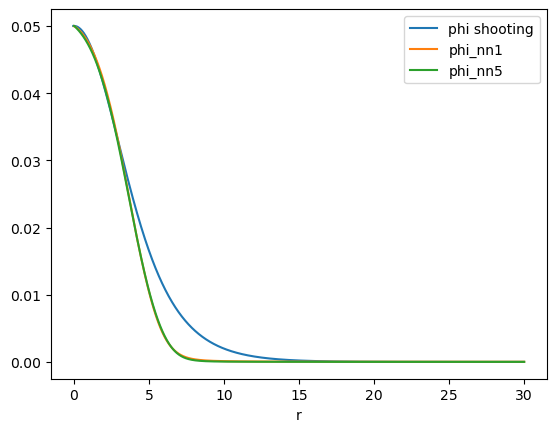

In [29]:
plt.plot(r, phi0, label="phi shooting")
plt.plot(R, phi_nn1, label="phi_nn1")
plt.plot(R, phi_nn5, label="phi_nn5")

print(phi_nn1[0])

plt.xlabel("r")
#plt.ylim(0,0.2)
plt.legend()